In [1]:
import numpy as np

from sklearn import linear_model
from tools.data_loading import load_images, load_labels, dummy_code, load_images_resized
from tools.feature_learning import pins_generation
from tools.hog import hog
from tools.kernels import kernel_matrix
from tools.optimization import find_f
from tools.prediction import pred
from tools.process_images import process_images
from tools.quantization import kmeans
from tools.submission import labels_to_csv
from tools.visualization import imshow, dump_as_png, reshape_as_images

# Data loading

In [2]:
X_train = load_images(type="train")
n_train = X_train.shape[0]
Y_labels_train = load_labels()
Y_train = dummy_code(Y_labels_train)
n_classes = Y_train.shape[1]

In [3]:
image_list = reshape_as_images(X_train)

# Visual features

In [4]:
filter_sigma=0.1
filter_shape=5
hog_cell_size=8
disc_grid=16

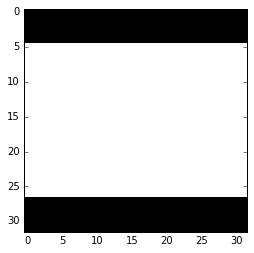

In [5]:
image = np.zeros((32,32,3))
image[5:27, :,:] = np.ones((22,32,3))
imshow(image)

In [6]:
hog(image,
   filter_sigma=filter_sigma, filter_shape=filter_shape, hog_cell_size=hog_cell_size, disc_grid=disc_grid)

array([[ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.]])

In [7]:
n_images = image_list.shape[0]

In [8]:
hog_list = []
for i in range(n_images):
    image = image_list[i,:,:,:]
    hog_list.append(
        hog(
            image,
            filter_sigma=filter_sigma,
            filter_shape=filter_shape,
            hog_cell_size=hog_cell_size,
            disc_grid=disc_grid))
    
n_features = hog_list[0].size
X_hog = np.array(hog_list).reshape((n_images, n_features)) 


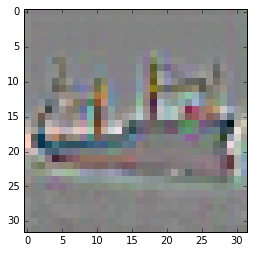

In [9]:
imshow(image_list[0])

In [10]:
np.set_printoptions(precision=2)
hog_list[0]

array([[ 0.08,  0.01,  0.01,  0.02,  0.03,  0.02,  0.05,  0.03],
       [ 0.02,  0.01,  0.02,  0.02,  0.02,  0.01,  0.01,  0.02],
       [ 0.06,  0.05,  0.01,  0.05,  0.11,  0.04,  0.04,  0.02],
       [ 0.  ,  0.  ,  0.01,  0.01,  0.08,  0.01,  0.02,  0.06],
       [ 0.22,  0.22,  0.25,  0.34,  0.25,  0.1 ,  0.07,  0.1 ],
       [ 0.24,  0.32,  0.18,  0.21,  0.13,  0.15,  0.15,  0.18],
       [ 0.5 ,  0.32,  0.26,  0.34,  0.31,  0.33,  0.25,  0.12],
       [ 0.19,  0.22,  0.14,  0.06,  0.29,  0.16,  0.18,  0.22],
       [ 0.08,  0.2 ,  0.07,  0.22,  0.67,  0.37,  0.55,  0.32],
       [ 0.01,  0.24,  0.15,  0.25,  0.57,  0.34,  0.07,  0.09],
       [ 0.06,  0.06,  0.  ,  0.2 ,  0.23,  0.17,  0.02,  0.03],
       [ 0.24,  0.44,  0.44,  0.01,  0.08,  0.33,  0.01,  0.16],
       [ 0.01,  0.03,  0.02,  0.03,  0.09,  0.05,  0.02,  0.04],
       [ 0.01,  0.01,  0.02,  0.02,  0.11,  0.08,  0.03,  0.01],
       [ 0.01,  0.01,  0.02,  0.04,  0.09,  0.05,  0.04,  0.01],
       [ 0.01,  0.02,  0.

In [11]:
X_hog.shape

(5000, 128)

In [12]:
X_hog[0]

array([ 0.08,  0.01,  0.01,  0.02,  0.03,  0.02,  0.05,  0.03,  0.02,
        0.01,  0.02,  0.02,  0.02,  0.01,  0.01,  0.02,  0.06,  0.05,
        0.01,  0.05,  0.11,  0.04,  0.04,  0.02,  0.  ,  0.  ,  0.01,
        0.01,  0.08,  0.01,  0.02,  0.06,  0.22,  0.22,  0.25,  0.34,
        0.25,  0.1 ,  0.07,  0.1 ,  0.24,  0.32,  0.18,  0.21,  0.13,
        0.15,  0.15,  0.18,  0.5 ,  0.32,  0.26,  0.34,  0.31,  0.33,
        0.25,  0.12,  0.19,  0.22,  0.14,  0.06,  0.29,  0.16,  0.18,
        0.22,  0.08,  0.2 ,  0.07,  0.22,  0.67,  0.37,  0.55,  0.32,
        0.01,  0.24,  0.15,  0.25,  0.57,  0.34,  0.07,  0.09,  0.06,
        0.06,  0.  ,  0.2 ,  0.23,  0.17,  0.02,  0.03,  0.24,  0.44,
        0.44,  0.01,  0.08,  0.33,  0.01,  0.16,  0.01,  0.03,  0.02,
        0.03,  0.09,  0.05,  0.02,  0.04,  0.01,  0.01,  0.02,  0.02,
        0.11,  0.08,  0.03,  0.01,  0.01,  0.01,  0.02,  0.04,  0.09,
        0.05,  0.04,  0.01,  0.01,  0.02,  0.02,  0.03,  0.09,  0.05,
        0.02,  0.01]

# Data separation

In [13]:
indices = np.random.permutation(X_hog.shape[0])
training_idx, test_idx = indices[:int(0.8*n_train)], indices[int(0.8*n_train):]

X_sample = X_hog[training_idx, :]
n_sample = X_sample.shape[0]
Y_sample = Y_train[training_idx,:]
Y_labels_sample = Y_labels_train[training_idx]

X_test = X_hog[test_idx, :]
n_test = X_test.shape[0]
Y_labels_test = Y_labels_train[test_idx]

# Training

## Kernel choice

In [14]:
kernel_type = "hellinger"
K_sample = kernel_matrix(X_sample, kernel_type=kernel_type)

In [15]:
K_sample.shape

(4000, 4000)

## Classifier choice

In [43]:
K_sample[cl_ind[dig]][:,cl_ind[dig]].shape
print(n_pos)

405


In [38]:
classifier_type = "svm"
alpha = np.zeros((n_classes, n_sample//5))
cl_ind = np.empty((n_classes, n_sample//5),dtype='uint8')
for dig in range(n_classes):
    pos_idx = np.where(Y_sample[:, dig] == 1)[0]
    neg_idx = np.where(Y_sample[:, dig] == 0)[0]
    n_pos = len(pos_idx)
    neg_idx = np.random.choice(neg_idx, n_sample//5 - n_pos)
   
    cl_ind[dig] = np.sort(np.concatenate((pos_idx, neg_idx)))
    alpha[dig, :] = find_f(K_sample[cl_ind[dig]][:,cl_ind[dig]], Y_sample[cl_ind[dig], dig],
                          prob_type=classifier_type, lamb=1, n_iter=90000)

# Evaluation

### Training error

In [39]:
Y_pred_train = np.zeros((X_sample[:500].shape[0], n_classes))
for dig in range(n_classes):
    Y_pred_train[:, dig] = pred(X_sample[cl_ind[dig]], X_sample[:500], alpha[dig, :],
                         kernel_type=kernel_type)


Y_labels_pred_train = np.argmax(Y_pred_train, axis=1)
prec = np.mean(Y_labels_pred_train == Y_labels_sample[:500])
print("The precision on the train set is of {}".format(prec))

The precision on the train set is of 0.382


### Testing error

In [40]:
Y_pred = np.zeros((X_test.shape[0], n_classes))
for dig in range(n_classes):
    Y_pred[:, dig] = pred(X_sample[cl_ind[dig]], X_test, alpha[dig, :],
                         kernel_type=kernel_type)


Y_labels_pred = np.argmax(Y_pred, axis=1)
prec = np.mean(Y_labels_pred == Y_labels_test)
print("The precision on the test set is of {}".format(prec))

The precision on the test set is of 0.258


# Prediction

In [ ]:
X_eval = load_images(type="test")
n_eval, n_var = X_eval.shape
image_list_eval = reshape_as_images(X_eval)

# Visual features for submission
hog_list_eval = []
for i in range(n_eval):
    image = image_list_eval[i,:,:,:]
    hog_list_eval.append(
        hog(
            image,
            filter_sigma=filter_sigma,
            filter_shape=filter_shape,
            hog_cell_size=hog_cell_size,
            disc_grid=disc_grid))
    
n_features = hog_list_eval[0].size
X_hog_eval = np.array(hog_list_eval).reshape((n_eval, n_features)) 

In [ ]:
Y_eval = np.zeros((n_eval, n_classes))
for dig in range(n_classes):
    Y_eval[:, dig] = pred(X_sample, X_hog_eval, alpha[dig, :],
                          kernel_type=kernel_type)


Y_labels_eval = np.argmax(Y_eval, axis=1)


# Submission
labels_to_csv(Y_labels_eval, kernel=kernel_type, algo="svm_hog",user="Pierre")